In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
DATASET_DIR = './data/sunspots'

data = pd.read_csv('Sunspots.csv', parse_dates=['Date'], index_col=['Date'])
data.rename(columns = {
    'Unnamed: 0': 'index',
    'Monthly Mean Total Sunspot Number': 'sunspots'
}, inplace = True)
data.head()

index  sunspots
Date                       
1749-01-31      0      96.7
1749-02-28      1     104.3
1749-03-31      2     116.7
1749-04-30      3      92.8
1749-05-31      4     141.7

/home/dzmitry/projects/stud/mo-env/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency A-DEC will be used.
  % freq, ValueWarning)
/home/dzmitry/projects/stud/mo-env/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency A-DEC will be used.
  % freq, ValueWarning)


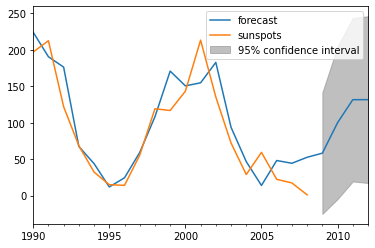

In [3]:
import statsmodels.api as sm

train = pd.Index(sm.tsa.datetools.dates_from_range('1749', '2008'))
test = pd.Index(sm.tsa.datetools.dates_from_range('1990', '2012'))
model = sm.tsa.ARIMA(data.sunspots[train], order=(10, 1, 0)).fit() 
model.plot_predict('1990', '2012');

In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense

TIME_PERIOD = 12

def build_model(input_shape):
    model = Sequential()
    model.add(GRU(TIME_PERIOD, input_shape=input_shape, return_sequences=True))
    model.add(GRU(TIME_PERIOD))
    model.add(Dense(1))
    return model

/home/dzmitry/projects/stud/mo-env/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/dzmitry/projects/stud/mo-env/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/dzmitry/projects/stud/mo-env/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/dzmitry/projects/stud/mo-env/lib/python3

In [10]:
mean = data.sunspots.mean()
std = data.sunspots.std()
data['sunspots_norm'] = (data.sunspots - mean) / std


In [11]:
import tensorflow as tf

BATCH_SIZE = 256

def get_dataset(df, time_period=TIME_PERIOD, shuffle=False, batch_size=BATCH_SIZE, raw=False):
    X = []
    y = []
    
    for i in range(time_period, len(df)):
        prev_v = np.array(df['sunspots_norm'][i-time_period:i])
        next_v = df['sunspots_norm'][i]
        
        X.append(prev_v)
        y.append(next_v)
        
    X = np.array(X)
    X = np.expand_dims(X, axis=-1)
    y = np.array(y)
    
    if raw:
        return X, y
    
    ds = tf.data.Dataset.from_tensor_slices((X, y))
    if shuffle:
        ds = ds.shuffle(10000)
    ds = ds.batch(batch_size).repeat()
    return ds

In [12]:
train_ds = get_dataset(data, shuffle=True)
test_ds = get_dataset(data)

In [26]:
model = build_model((12, 1))
model.compile(loss='mse', optimizer='adam')

In [18]:
from tensorflow.keras.callbacks import EarlyStopping

history = model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=10,
    steps_per_epoch=100,
    validation_steps=30,
)

Epoch 1/10
100/100 [==============================] - 2s 16ms/step - loss: 0.3997 - val_loss: 0.1739
Epoch 2/10
100/100 [==============================] - 1s 10ms/step - loss: 0.1697 - val_loss: 0.1562
Epoch 3/10
100/100 [==============================] - 1s 10ms/step - loss: 0.1555 - val_loss: 0.1452
Epoch 4/10
100/100 [==============================] - 1s 10ms/step - loss: 0.1464 - val_loss: 0.1393
Epoch 5/10
100/100 [==============================] - 1s 10ms/step - loss: 0.1413 - val_loss: 0.1359
Epoch 6/10
100/100 [==============================] - 1s 10ms/step - loss: 0.1385 - val_loss: 0.1340
Epoch 7/10
100/100 [==============================] - 1s 10ms/step - loss: 0.1369 - val_loss: 0.1332
Epoch 8/10
100/100 [==============================] - 1s 10ms/step - loss: 0.1376 - val_loss: 0.1330
Epoch 9/10
100/100 [==============================] - 1s 10ms/step - loss: 0.1360 - val_loss: 0.1318
Epoch 10/10
100/100 [==============================] - 1s 10ms/step - loss: 0.1357 - val_lo

In [21]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(data, test_size=0.3, shuffle=False)
test, val = train_test_split(test, test_size=0.5, shuffle=False)

In [22]:
X_test, y_test = get_dataset(test, raw=True)
X_val, y_val = get_dataset(val, raw=True)

In [23]:
test_loss = model.evaluate(X_test, y_test)
val_loss = model.evaluate(X_val, y_val)

print(f'Test loss:\t{test_loss:.2%}')
print(f'Validation loss:\t{val_loss:.2%}')

476/476 [==============================] - 0s 72us/sample - loss: 0.1142
Test loss:	14.66%
Validation loss:	11.42%


In [24]:
mean = data.sunspots.mean()
std = data.sunspots.std()

def predict(X):
    shift = [None] * TIME_PERIOD
    predict = mean + model.predict(X) * std
    return shift + list(predict.flatten())

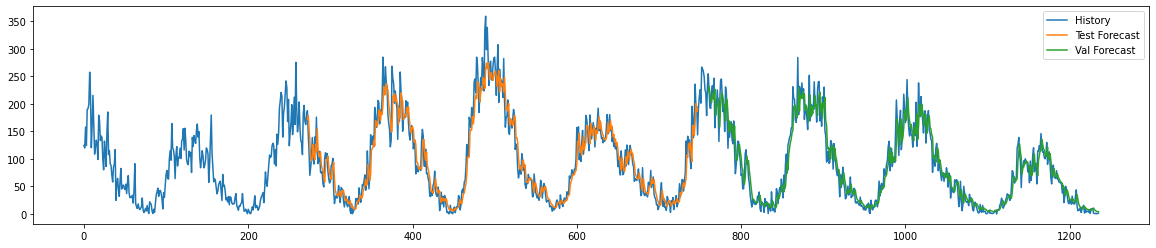

In [25]:
HISTORY_FROM = '1917'
history = data.loc[HISTORY_FROM:]
train_size = len(train.loc[HISTORY_FROM:])
train_with_test_size = train_size + len(test)
full_size = train_with_test_size + len(val)

plt.figure(figsize=(20, 4))
plt.plot(np.arange(full_size), history.sunspots, label='History')
plt.plot(np.arange(train_size, train_with_test_size), predict(X_test), label='Test Forecast')
plt.plot(np.arange(train_with_test_size, full_size), predict(X_val), label='Val Forecast')
plt.legend()
plt.show()